In [1]:
# run in one batch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# scipy imports
import scipy.stats as stats

# sklearn imports
from sklearn.linear_model import LinearRegression

In [2]:
# load q data
q_df = pd.read_csv('q-data/gunnison_delta.csv',sep='\t',header=32)
q_df.columns = ['USGS', 'id', 'dt_string', 'tz', 'cfs', 'junk']

# datetime operations
q_df['dt'] = pd.to_datetime(q_df['dt_string'])
q_df['year'] = q_df['dt'].dt.year
q_df['month'] = q_df['dt'].dt.month
q_df['day'] = q_df['dt'].dt.day

# new datetime without time
q_df['timestamp'] = pd.to_datetime(q_df[['year','month', 'day']], errors='coerce')

# make series from groupby, this has timestamp as index
daily_q = q_df.groupby(['timestamp'])['cfs'].mean()

# make df from series
daily_q_df = pd.DataFrame(daily_q)

# annual peak Q
#peak_q = q_df.groupby(q_df.year)['cfs'].max()

# cumulative Q
#sum_q = q_df.groupby(q_df.year)['cfs'].cumsum()

In [3]:
# load snotel data
stationnames = ['680_park_cone','762_slumgullion','701_porphyry_creek','737_schofield_pass','682_park_reservoir',
                '669_north_lost_trail','1059_cochetopa_pass']
data_lst = []
count = 0
for stationname in stationnames:
    snow_df = pd.read_csv('snotel-data/snotel_{}.csv'.format(stationname),header=58) 
    snow_df.columns = ['date', 'swe_start_in',
       'precip_start_in',
       'airtemp_max_F', 'airtemp_min_F',
       'airtemp_mean_F', 'precip_incr_in']
    # datetime operations
    snow_df['dt'] = pd.to_datetime(snow_df['date'])
    snow_df['year'] = snow_df['dt'].dt.year

    # remove rows with swe=0
    snow_df.drop(snow_df[snow_df.swe_start_in == 0].index, inplace=True)

    #set snow df index to dt
    snow_df.set_index(snow_df.dt, inplace=True)

    # annual peak swe
    #peak_swe = snow_df.groupby(snow_df.year)['swe_start_in'].max()

    # annual sum swe
    #sum_swe = snow_df.groupby(snow_df.year)['swe_start_in'].cumsum()

    # merge datasets
    merged_df = pd.merge(snow_df, daily_q_df, how='left', left_index=True, right_index=True)

    data_lst.append(merged_df)
    count += 1
print(count)
data_df = pd.concat(data_lst, axis=0, ignore_index = True)

7


In [4]:
#data_lst[2].tail()

In [17]:
data_df.tail()

,date,swe_start_in,precip_start_in,airtemp_max_F,airtemp_min_F,airtemp_mean_F,precip_incr_in,dt,year,cfs
50708,2018-03-09,2.6,4.3,44.0,21.0,33.0,0.0,2018-03-09,2018,899.479167
50709,2018-03-10,2.6,4.3,42.0,25.0,34.0,0.0,2018-03-10,2018,902.010417
50710,2018-03-11,2.5,4.3,41.0,22.0,31.0,NaN,2018-03-11,2018,920.728261
50711,2018-03-12,2.5,4.2,45.0,21.0,32.0,0.1,2018-03-12,2018,919.541667
50712,2018-03-13,2.5,4.3,NaN,NaN,NaN,NaN,2018-03-13,2018,913.981481


In [5]:
data_df.describe()

,swe_start_in,precip_start_in,airtemp_max_F,airtemp_min_F,airtemp_mean_F,precip_incr_in,year,cfs
count,50496.000000,50491.000000,44873.000000,45143.000000,45262.000000,50472.000000,50713.000000,40888.000000
mean,11.116140,13.659696,38.506429,13.262676,24.520812,0.105015,1999.767634,1749.395044
std,9.853998,10.697031,14.185656,13.432429,12.195088,0.225709,10.889317,1696.987183
min,0.100000,0.000000,-60.000000,-60.000000,-60.000000,0.000000,1978.000000,294.708333
25%,3.800000,5.500000,30.000000,5.000000,17.000000,0.000000,1991.000000,828.291667
50%,8.600000,10.800000,38.000000,14.000000,25.000000,0.000000,2000.000000,1146.041667
75%,15.200000,18.900000,47.000000,23.000000,33.000000,0.100000,2009.000000,1963.191489
max,61.200000,69.800000,257.000000,257.000000,257.000000,4.000000,2018.000000,15335.416667


In [6]:
# clean outliers (drop rows)
df = data_df
# clear min airtemp outliers
df.drop(df[df.airtemp_min_F > 65].index, inplace=True)
df.drop(df[df.airtemp_min_F < -40].index, inplace=True)
# clear max airtemp outliers
df.drop(df[df.airtemp_max_F > 120].index, inplace=True)
df.drop(df[df.airtemp_max_F < -50].index, inplace=True)
data_clean = df 

# # binned regression
# bins = 200
# bins, binvals = pd.cut(data_clean.airtemp_min_F,bins,right=True,retbins=True)
# data_clean['bins'] = bins.values
# maxQ_mintemp = data_clean.groupby(data_clean.bins)['cfs'].max()
# #ok here

# # data for new regression
# meanSWE_mintemp = data_clean.groupby(data_clean.bins)['swe_start_in'].mean()
# meanAIR_mintemp = data_clean.groupby(data_clean.bins)['airtemp_min_F'].mean()
# data_binned = pd.concat([meanSWE_mintemp,meanAIR_mintemp,maxQ_mintemp], axis=1)
# # ok here

# # drop nans
# data_clean_binned = data_binned.dropna()

# drop nans
data_clean = data_clean.dropna()

In [7]:
np.shape(data_clean)


(39584, 10)

In [11]:
data_clean.head()

,date,swe_start_in,precip_start_in,airtemp_max_F,airtemp_min_F,airtemp_mean_F,precip_incr_in,dt,year,cfs
1178,1985-12-12,6.9,7.4,30.0,-33.0,-5.0,0.0,1985-12-12,1985,2512.395833
1181,1985-12-15,6.8,7.4,36.0,-18.0,3.0,0.0,1985-12-15,1985,2709.687500
1182,1985-12-16,6.8,7.4,36.0,-9.0,10.0,0.0,1985-12-16,1985,2708.854167
1192,1985-12-26,6.7,7.4,36.0,-12.0,9.0,0.0,1985-12-26,1985,2710.416667
1195,1985-12-29,6.7,7.4,40.0,-12.0,10.0,0.0,1985-12-29,1985,2715.520833


R2 = 0.215


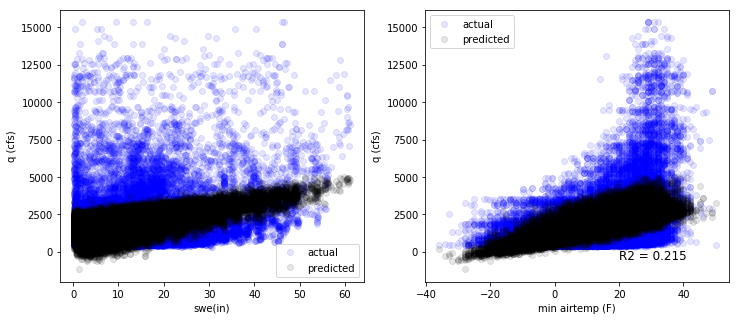

In [15]:
model_df = data_clean
cols = model_df.columns
# regression again
X = model_df[['swe_start_in','airtemp_max_F','airtemp_min_F']]
y = model_df['cfs']

model = LinearRegression()
model.fit(X,y)
y_hat = model.predict(X)

# R2 score
score = model.score(X,y)
print('R2 = {0:.3f}'.format(score))

# plot predictions
# plots swe A, B
fig, ax = plt.subplots(1,2,figsize=(12,5));
ax[0].plot(model_df.swe_start_in,y,'bo',alpha=0.1)
ax[0].set_ylabel('q (cfs)');
ax[0].set_xlabel('swe(in)')
ax[0].plot(model_df.swe_start_in,y_hat,'ko',alpha=0.1)
ax[0].legend(['actual','predicted'])

ax[1].plot(model_df.airtemp_min_F,y,'bo',alpha=0.1)
ax[1].set_ylabel('q (cfs)');
ax[1].set_xlabel('min airtemp (F)')
ax[1].plot(model_df.airtemp_min_F,y_hat,'ko',alpha=0.1)
ax[1].legend(['actual','predicted'])

figname = 'gunnison_river_7stations_nobins'
plt.text(20,-500,'R2 = {0:.3f}'.format(score),fontsize=12)
plt.savefig('{}.pdf'.format(figname),format='pdf')

In [10]:
np.shape(X)

(85, 2)

In [11]:
np.shape(y)

(85,)

In [12]:


# plot predictions
# plots swe A, B
# fig, ax = plt.subplots(1,3,figsize=(12,5));
# ax[0].plot(data_clean.swe_start_in,y,'bo',alpha=0.1)
# ax[0].set_ylabel('q (cfs)');
# ax[0].set_xlabel('swe(in)')
# ax[0].plot(data_clean.swe_start_in,y_hat,'ko',alpha=0.1)

# ax[1].plot(data_clean.airtemp_min_F,y,'bo',alpha=0.1)
# ax[1].set_ylabel('q (cfs)');
# ax[1].set_xlabel('min airtemp (F)')
# ax[1].plot(data_clean.airtemp_min_F,y_hat,'ko',alpha=0.1)

# ax[2].plot(data_clean.airtemp_max_F,y,'bo',alpha=0.1)
# ax[2].set_ylabel('q (cfs)');
# ax[2].set_xlabel('max airtemp (F)')
# ax[2].plot(data_clean.airtemp_max_F,y_hat,'ko',alpha=0.1)